In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import  MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping
from pandas.tseries.offsets import CustomBusinessMonthBegin

In [2]:
df = pd.read_csv('sp500_Adjclose.csv')

df['Date'] = pd.to_datetime(df.Date)

df.set_index('Date', inplace=True)


In [3]:
ticker = input('> What is the ticker for the company'
               ' whose adjusted close value you want to predict for? \n>').upper()

df = df.loc[:,[f'{ticker}']]

df = df.resample('1M').mean()

> What is the ticker for the company whose adjusted close value you want to predict for? 
>mmm


In [4]:
len(df)

test_size = int(input(">What is your test set size in months? \nIdeally less than 24 months \n"))

len(df)- test_size

>What is your test set size in months? 
Ideally less than 24 months 
18


224

In [5]:
test_ind = len(df)- test_size

In [6]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [7]:
train

,MMM
Date,
2000-01-31,26.994161
2000-02-29,24.795302
2000-03-31,24.288003
2000-04-30,25.987985
2000-05-31,24.487872
...,...
2018-04-30,199.112898
2018-05-31,188.358998
2018-06-30,189.831294


In [8]:
test

,MMM
Date,
2018-09-30,201.264673
2018-10-31,190.910536
2018-11-30,191.170284
2018-12-31,186.176839
2019-01-31,184.784626
2019-02-28,197.726914
2019-03-31,199.081088
2019-04-30,203.466542
2019-05-31,166.782777


In [9]:
scaler = MinMaxScaler()

In [10]:
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [11]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [12]:
length = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

In [13]:
X,y = generator[0]

In [14]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.01413175 0.00341863 0.000947   0.00922953 0.00192079 0.
 0.00541476 0.01391027 0.00766245 0.01263887 0.0194618  0.04550258]
Predict this y: 
 [[0.04239666]]


In [15]:
n_features = 1

In [16]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [18]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [19]:
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, length=length, batch_size=1)

In [20]:
model.fit_generator(generator,epochs=14,
                    validation_data=validation_generator)

Epoch 1/14
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
212/212 [==============================] - 9s 42ms/step - loss: 0.0167 - val_loss: 0.0121
Epoch 2/14
212/212 [==============================] - 3s 16ms/step - loss: 0.0033 - val_loss: 0.0195
Epoch 3/14
212/212 [==============================] - 3s 15ms/step - loss: 0.0025 - val_loss: 0.0019
Epoch 4/14
212/212 [==============================] - 3s 16ms/step - loss: 0.0023 - val_loss: 0.0014
Epoch 5/14
212/212 [==============================] - 3s 16ms/step - loss: 0.0022 - val_loss: 0.0082
Epoch 6/14
212/212 [==============================] - 3s 16ms/step - loss: 0.0019 - val_loss: 0.0066
Epoch 7/14
212/212 [==============================] - 3s 16ms/step - loss: 0.0016 - val_loss: 0.0036
Epoch 8/14
212/212 [==============================] - 3s 16ms/step - loss: 0.0014 - val_loss: 0.0020
Epoch 9/14
212/212 [==============================] - 3s 16ms/step - loss: 0.0015 - val_loss: 0.00

In [21]:
losses = pd.DataFrame(model.history.history)

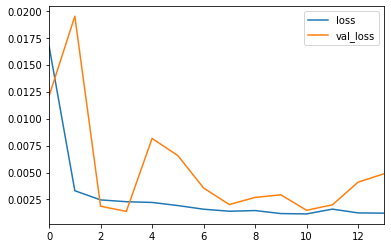

In [22]:
losses.plot()

In [23]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    
    test_predictions.append(current_pred) 
    
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
    
    

In [24]:
true_predictions = scaler.inverse_transform(test_predictions)

In [25]:
test['Predictions'] = true_predictions

C:\Users\khatt\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [26]:
test

,MMM,Predictions
Date,,
2018-09-30,201.264673,206.424861
2018-10-31,190.910536,212.129740
2018-11-30,191.170284,219.460528
2018-12-31,186.176839,227.466744
2019-01-31,184.784626,235.756050
2019-02-28,197.726914,243.890745
2019-03-31,199.081088,251.743892
2019-04-30,203.466542,259.453096
2019-05-31,166.782777,267.270422


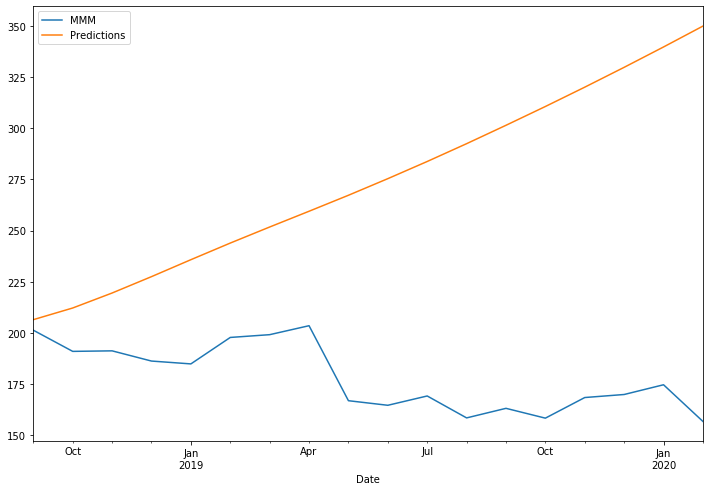

In [27]:
test.plot(figsize=(12,8))

In [28]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [29]:
length = 12 # Length of the output sequences (in number of timesteps)
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=1)

In [30]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


# fit model
model.fit_generator(generator,epochs=20)

Epoch 1/20
230/230 [==============================] - 11s 49ms/step - loss: 0.0213
Epoch 2/20
230/230 [==============================] - 5s 20ms/step - loss: 0.0031
Epoch 3/20
230/230 [==============================] - 4s 19ms/step - loss: 0.0030
Epoch 4/20
230/230 [==============================] - 4s 18ms/step - loss: 0.0027
Epoch 5/20
230/230 [==============================] - 4s 17ms/step - loss: 0.0019
Epoch 6/20
230/230 [==============================] - 4s 18ms/step - loss: 0.0020
Epoch 7/20
230/230 [==============================] - 4s 19ms/step - loss: 0.0019
Epoch 8/20
230/230 [==============================] - 5s 20ms/step - loss: 0.0018
Epoch 9/20
230/230 [==============================] - 4s 19ms/step - loss: 0.0017
Epoch 10/20
230/230 [==============================] - 4s 19ms/step - loss: 0.0017
Epoch 11/20
230/230 [==============================] - 4s 19ms/step - loss: 0.0016
Epoch 12/20
230/230 [==============================] - 4s 19ms/step - loss: 0.0014-
Epoch 13/20

In [31]:
forecast = []

In [32]:
periods = 12

In [33]:
first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

In [34]:
for i in range(periods):
    current_pred = model.predict(current_batch)[0]
    
    forecast.append(current_pred) 
    
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
    
    

In [35]:
forecast = scaler.inverse_transform(forecast)

In [36]:
df

,MMM
Date,
2000-01-31,26.994161
2000-02-29,24.795302
2000-03-31,24.288003
2000-04-30,25.987985
2000-05-31,24.487872
...,...
2019-10-31,158.249711
2019-11-30,168.334397
2019-12-31,169.818376


In [37]:
forecast_index = pd.date_range(start='2020-03-31',periods=periods,freq='MS')

In [38]:
forecast_df = pd.DataFrame(data=forecast,index=forecast_index,
                           columns=['Forecast'])

In [39]:
forecast_df

,Forecast
2020-04-01,161.319456
2020-05-01,160.086766
2020-06-01,158.749049
2020-07-01,157.340130
2020-08-01,156.032912
2020-09-01,154.989051
2020-10-01,153.991788
2020-11-01,153.018613
2020-12-01,152.069074
2021-01-01,151.213540


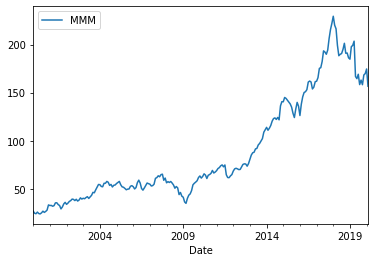

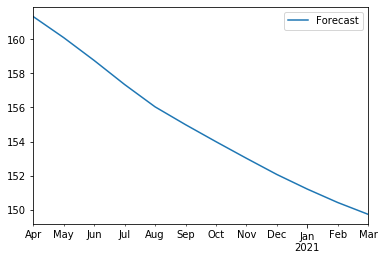

In [40]:
df.plot()
forecast_df.plot()

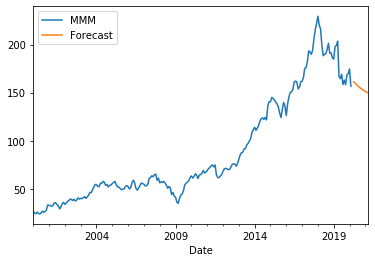

In [41]:
ax = df.plot()
forecast_df.plot(ax=ax)

(576, 623)

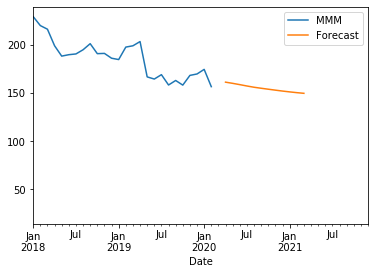

In [42]:
ax = df.plot()
forecast_df.plot(ax=ax)
plt.xlim('2018-01-01','2021-12-01')